In [1]:
# Libraries to load
import pandas as pd
import numpy as np 
from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# data visualization packages 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
pd.set_option('max_columns', None)
import pandas_profiling

# machine learning packages (sklearn + xgboost)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV, RFE
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')
np.random.seed(123)

In [2]:
# Load DF
df = pd.read_csv('./data/cleaned_df.csv')

In [3]:
# Format Readmitted
df['readmitted'] = df.readmitted.map({'No':0,'Yes':1})

# Dropping Features

In [4]:
#shortest drop list - no patients take these medications
df = df.drop(columns = ["examide", "citoglipton"])

# Feature Engineering

In [5]:
# Group admission type by Emergency (Emergency, Trauma Center, and Urgent), Elective, and Other

def modadtype(series):
    
    def newcat(x):
        if x == 1 or x == 2 or x == 7: return "Emergency"
        elif x == 3: return "Elective"
        else: return "Other"
        
    return series.apply(newcat)

df.admission_type_id = modadtype(df.admission_type_id)

In [6]:
# Group admission source by Referral, Emergency, and Other

def modadsourc(series):
    
    def newcat(x):
        if x == 1 or x == 2 or x == 3: return "Referral"
        elif x == 7: return "Emergency"
        else: return "Other"
        
    return series.apply(newcat)

df.admission_source_id = modadsourc(df.admission_source_id)

In [7]:
## Group discharge dispo by Home or Not_Home discharge

def moddisch(series):
    
    def home(x):
        if x == 1: return "Home"
        else: return "Not_Home"
    
    return series.apply(home)

df.discharge_disposition_id = moddisch(df.discharge_disposition_id)

## Other method - Remove Expired or Hospice-bound Patients

#remove only hospice bound and expired
# df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [8]:
# Change medication to binary take vs not take - play with post model creation
#for med in medication:
    #df[med] = df[med].map({'Up':1, 'Down':1, 'Steady':1, 'No':0})


# medication = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
#        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
#        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
#        'tolazamide', 'insulin',
#        'glyburide-metformin', 'glipizide-metformin',
#        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
#        'metformin-pioglitazone']

In [9]:
# Group age by most common categories
age_id = {'[0-10)':'30 or Under', 
          '[10-20)':'30 or Under', 
          '[20-30)':'30 or Under', 
          '[30-40)':'30 to 60', 
          '[40-50)':'30 to 60', 
          '[50-60)':'30 to 60',
          '[60-70)':'30 to 60', 
          '[70-80)':'Over 60', 
          '[80-90)':'Over 60', 
          '[90-100)':'Over 60'}
df['age'] = df.age.replace(age_id)

In [10]:
# Group race by most common categories
race_id = {'Caucasian':'Caucasian', 
          'AfricanAmerican':'AfricanAmerican', 
          'Other':'Other', 
          'Asian':'Other', 
          'Hispanic':'Other', 
          'unknown':'Missing',}
df['race'] = df.race.replace(race_id)

In [11]:
# Inspect Unknown/Invalid results for Gender
df[df['gender'].str.contains('Unknown/Invalid')]

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
22926,Other,Unknown/Invalid,Over 60,Elective,Home,Referral,1,5,5,22,0,0,0,414,411,401,4,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,0
55129,Missing,Unknown/Invalid,30 to 60,Emergency,Home,Emergency,1,38,1,6,0,0,0,808,873,E813,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
59490,Missing,Unknown/Invalid,Over 60,Emergency,Not_Home,Emergency,8,59,2,21,0,0,0,850,805,808,9,None,None,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Ch,Yes,0


In [12]:
# Only 3 values of unknown gender; drop those observations
df = df[df.gender != "Unknown/Invalid"]

In [13]:
# Create a function to group diagnostic codes by range as well as separating diabetes specifically; group symptoms with major disease category

def diag_grouper(series):
    
    '''takes input as df.col and outputs diagnostic code groupings'''
    
    def no_str(x):
        
        '''takes input as an element of a series and pulls code for diabetes specific disease and E/V categories'''
        
        if '250' in x: return '9999'
        elif 'E' in x: return '123456'
        elif 'V' in x: return '123456'
        elif x == 'missing': return '-654321'
        else: return x
    
    series = series.apply(no_str)
    
    series = series.astype(float)
    
    def num_categ(x):
        
        '''takes input as an element of a series and saves each range as a numerical placeholder'''
        
        if 1 <= x <= 139: return 10000
        elif 140 <= x <= 239: return 10001
        elif 240 <= x <= 279: return 10002
        elif 280 <= x <= 289: return 10003
        elif 290 <= x <= 319: return 10004
        elif 320 <= x <= 359: return 10005
        elif 360 <= x <= 389: return 10006
        elif 390 <= x <= 459 and x == 786: return 10007
        elif 460 <= x <= 519 and x == 787: return 10008
        elif 520 <= x <= 579 and x == 787: return 10009
        elif 580 <= x <= 629 and x == 788: return 10010
        elif 630 <= x <= 679: return 10011
        elif 680 <= x <= 709 and x == 782: return 10012
        elif 710 <= x <= 739: return 10013
        elif 740 <= x <= 759: return 10014
        elif 780 <= x <= 781 and x == 784 and 790 <= x <= 799: return 10015
        elif 800 <= x <= 999: return 10016
        else: return x
        
    series = series.apply(num_categ)
    
    def text_convert(x):
        
        '''takes input as an element of a series and converts each placeholder to string format'''
        
        if x == 10000: return "Other"
        elif x == 10001: return "Neoplasms"
        elif x == 10002: return "Other"
        elif x == 10003: return "Other"
        elif x == 10004: return "Other"
        elif x == 10005: return "Other"
        elif x == 10006: return "Other"
        elif x == 10007: return "Circulatory Disease"
        elif x == 10008: return "Respiratory Disease"
        elif x == 10009: return "Digestive Disease"
        elif x == 10010: return "Genitourinary"
        elif x == 10011: return "Other"
        elif x == 10012: return "Other"
        elif x == 10013: return "Musculoskeletal Disease"
        elif x == 10014: return "Other"
        elif x == 10015: return "Other"
        elif x == 10016: return "Injury and Poisoning"
        elif x == 9999: return "Diabetes"
        elif x == 123456: return "Other"
        elif x == -654321: return "Other"
    
    return series.apply(text_convert)

In [14]:
# Apply diag_grouper to the data frame
df.diag_1 = diag_grouper(df.diag_1)
df.diag_2 = diag_grouper(df.diag_2)
df.diag_3 = diag_grouper(df.diag_3)

In [15]:
# Create boolean masks for the columns in question and convert to int
Circ = df[['diag_1','diag_2','diag_3']].isin(['Circulatory Disease']).astype(int)
Resp = df[['diag_1','diag_2','diag_3']].isin(['Respiratory Disease']).astype(int)
Digest = df[['diag_1','diag_2','diag_3']].isin(['Digestive Disease']).astype(int)
Diab = df[['diag_1','diag_2','diag_3']].isin(['Diabetes']).astype(int)
Genit = df[['diag_1','diag_2','diag_3']].isin(['Genitourinary']).astype(int)
Muscu = df[['diag_1','diag_2','diag_3']].isin(['Musculoskeletal Disease']).astype(int)
Neop = df[['diag_1','diag_2','diag_3']].isin(['Neoplasms']).astype(int)
Inj = df[['diag_1','diag_2','diag_3']].isin(['Injury and Poisoning']).astype(int)
Othr = df[['diag_1','diag_2','diag_3']].isin(['Other']).astype(int)

In [16]:
# Sum the column amounts
Circulatory = (Circ['diag_1'] + Circ['diag_2'] + Circ['diag_3'])
Respiratory = Resp['diag_1'] + Resp['diag_2'] + Resp['diag_3']
Digestive = Digest['diag_1'] + Digest['diag_2'] + Digest['diag_3']
Diabetes = Diab['diag_1'] + Diab['diag_2'] + Diab['diag_3']
Injury = Inj['diag_1'] + Inj['diag_2'] + Inj['diag_3']
Genitourinary = Genit['diag_1'] + Genit['diag_2'] + Genit['diag_3']
Musculoskeletal = Muscu['diag_1'] + Muscu['diag_2'] + Muscu['diag_3']
Neoplasms = Neop['diag_1'] + Neop['diag_2'] + Neop['diag_3']
Other = Othr['diag_1'] + Othr['diag_2'] + Othr['diag_3']

In [17]:
# Create new df of new diag columns; convert back to boolean then back to int to binarize
newcollist = [Circulatory, Respiratory, Digestive, Diabetes, Injury, Genitourinary, Musculoskeletal, Neoplasms, Other]
newcols = pd.concat(newcollist, axis = 1)
newcols.columns = ['diag_Circulatory', 'diag_Respiratory', 'diag_Digestive', 'diag_Diabetes', 'diag_Injury',
                   'diag_Genitourinary', 'diag_Musculoskeletal', 'diag_Neoplasms','diag_Other']
newcols = newcols.astype(bool).astype(int)

In [18]:
# Drop OG diags and add new
df = df.drop(columns = ['diag_1','diag_2','diag_3'])
df = pd.concat([df,newcols],axis=1)

# Separation for Scaling and Encoding

In [19]:
# identify cat and num types for cat dummification
categorical = df.drop(columns = ['time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
        'number_diagnoses', 'diag_Circulatory', 'diag_Respiratory',
       'diag_Digestive', 'diag_Diabetes', 'diag_Neoplasms', 'diag_Injury', 
       'diag_Genitourinary', 'diag_Musculoskeletal', 
        'diag_Other','readmitted'])
numerical = df.drop(columns = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 
       'max_glu_serum', 'A1Cresult', 'diag_Circulatory', 'diag_Respiratory',
       'diag_Digestive', 'diag_Diabetes', 'diag_Injury', 'diag_Other',                        
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'diag_Genitourinary', 'diag_Musculoskeletal', 'diag_Neoplasms',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','readmitted'])


In [20]:
# Export for graphing post variable grouping
#df.to_csv(r'./data/cleaned_df.csv', index = False)

In [21]:
# Separation of features from target for dummification

X = df.drop('readmitted', axis = 1)
y = df['readmitted']

In [22]:
X = pd.get_dummies(X, columns = categorical.columns)

#### Recombine data frame for 80/20 split

In [23]:
df = X.assign(readmitted = y)

In [24]:
# Perform and 80/20 split of the data
X = df.drop('readmitted', axis = 1)
y = df['readmitted']


In [25]:
X.shape

(71515, 112)

In [26]:
#fit RFE to the Training Data

# evaluate RFE for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

rfecv = RFECV(estimator = DecisionTreeClassifier(), step=1,
              cv=StratifiedKFold(5), scoring='accuracy')

rfecv.fit(X,y)

#print("Optimal number of features : %d" % rfecv.n_features_)



# # create pipeline
# rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=80)
# model = DecisionTreeRegressor()
# pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# # evaluate model
# cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# # report performance
# print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), scoring='accuracy')

In [27]:
# summarize all features
cols = []
for i in range(X.shape[1]):
    if rfecv.ranking_[i] <= 45:
        cols.append(i)

In [28]:
X_ = X.iloc[:, cols]

In [53]:
# split

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.2, stratify = y, random_state = 123)

In [54]:
X_

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,diag_Diabetes,diag_Injury,diag_Musculoskeletal,diag_Neoplasms,diag_Other,race_AfricanAmerican,race_Caucasian,gender_Female,gender_Male,age_30 to 60,age_Over 60,admission_type_id_Elective,admission_type_id_Emergency,admission_type_id_Other,discharge_disposition_id_Home,admission_source_id_Emergency,admission_source_id_Other,admission_source_id_Referral,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,glimepiride_Steady,glipizide_No,glipizide_Steady,glyburide_No,glyburide_Steady,pioglitazone_No,rosiglitazone_No,rosiglitazone_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No
0,1,41,0,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,1
1,3,59,0,18,0,0,0,9,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,1,0
2,2,11,5,13,2,0,1,6,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,1
3,2,44,1,16,0,0,0,7,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,1,0
4,1,51,0,8,0,0,0,5,1,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71513,9,50,2,33,0,0,0,9,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0
71514,14,73,6,26,0,1,0,9,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,0,1,1,0
71515,2,46,6,17,1,1,1,9,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1
71516,5,76,1,22,0,1,0,9,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,1,0


# Balancing the Data Set

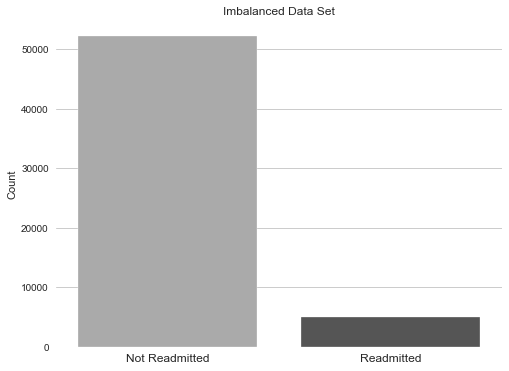

In [55]:
plt.figure(figsize=(8,6))
sns.countplot(y_train, palette='binary')
sns.despine()
sns.set_style('whitegrid')
plt.title('Imbalanced Data Set')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'], size = 12)
plt.xlabel('')
plt.ylabel('Count')
plt.show()

In [57]:
# SMOTE 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=123)
X_train_smo, y_train_smo = sm.fit_sample(X_train, y_train)


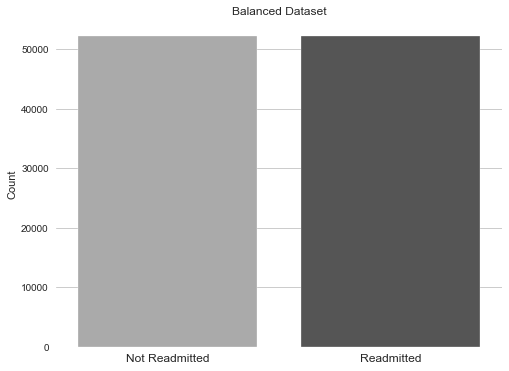

In [58]:
plt.figure(figsize=(8,6))
sns.countplot(y_train_smo, palette='binary')
sns.despine()
sns.set_style('whitegrid')
plt.title('Balanced Dataset')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'], size = 12)
plt.xlabel('')
plt.ylabel('Count')
plt.show()

## Model Base Line

In [59]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [60]:
thresh = 0.5

## Logistic regression

- Confusion Matrix 

In [121]:
# create model logistic as logistic regression using Sklearn 
from sklearn.linear_model import LogisticRegression
logisticreg = LogisticRegression(tol=1e-7, penalty='l2', C=0.0005, random_state = 123)
logisticreg.fit(X_train_smo, y_train_smo)
Ylog = logisticreg.predict(X_test)

In [122]:
# Checking the accuracy of the model 
print(" The accuracy of the Logistic regression model:" ,logisticreg.score(X_test, y_test))

 The accuracy of the Logistic regression model: 0.8810739005802979


In [123]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, Ylog))

[[12551   493]
 [ 1208    51]]


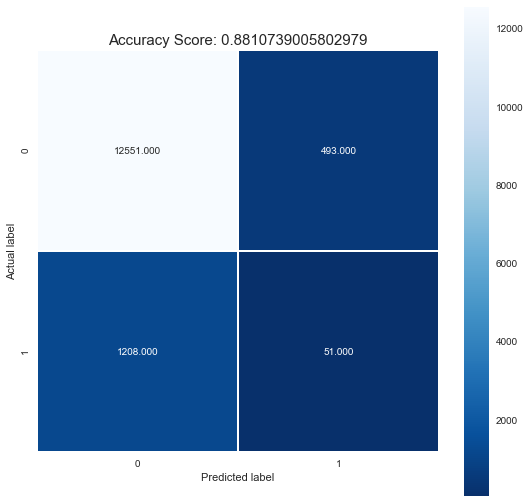

In [124]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(y_test, Ylog), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(logisticreg.score(X_test, y_test))
plt.title(all_sample_title, size = 15);

In [109]:
# Checking the summary of classification
from sklearn.metrics import classification_report
print(classification_report(y_test, Ylog, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.91      0.94      0.93     13044
         YES       0.11      0.07      0.09      1259

    accuracy                           0.86     14303
   macro avg       0.51      0.51      0.51     14303
weighted avg       0.84      0.86      0.85     14303



In [110]:
YScre = logisticreg.decision_function(X_test)

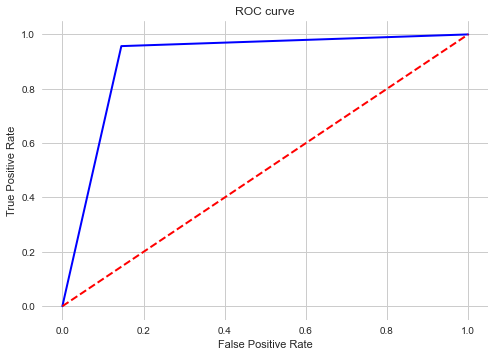

In [126]:
##Computing false and true positive rates
from sklearn.metrics import roc_curve

fpr, tpr,_=roc_curve(logisticreg.predict(X_train_smo),y_train_smo,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()
##Creating the ROC,
plt.plot(fpr, tpr, color='blue',
 lw=2, label='ROC curve')
##Finding FPR and TPR,
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
##Splecifying the label and title,
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

- Model

In [112]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 123)
lr = lr.fit(X_train_smo, y_train_smo)

In [113]:
y_train_preds = lr.predict_proba(X_train)[:,1]
y_valid_preds = lr.predict_proba(X_test)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Test:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_test,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.530
accuracy:0.868
recall:0.068
precision:0.106
specificity:0.945
prevalence:0.088
 
Test:
AUC:0.524
accuracy:0.864
recall:0.072
precision:0.105
specificity:0.941
prevalence:0.088
 


In [114]:
readmit_proba = [i[1] for i in lr.predict_proba(X_test)]
quant = pd.qcut(readmit_proba,10,labels=np.arange(1,11))
prob = {'Quantile':quant,'# Readmitted':readmit_proba,'y':y_test}

deciles_lr = pd.DataFrame(prob).sort_values('Quantile')
dec1 = deciles_lr.groupby('Quantile')['# Readmitted'].agg(['count','min','max','mean']).reset_index()
dec2 = deciles_lr.groupby(['Quantile','y']).count().reset_index()
dec2 = dec2[dec2['y']==1]
deciles_lr = pd.merge(dec2, dec1, how='inner',on ='Quantile').drop('y',1).\
        rename({'count':'Unique Patients', 'min':'Min Prob', 'mean':'Average Prob','max':'Max Prob'},axis=1)

deciles_lr = deciles_lr[deciles_lr.columns[[0,2,1,3,4,5]]]
deciles_lr['Percent Readmitted'] = deciles_lr['# Readmitted']/deciles_lr['Unique Patients']
deciles_lr['Lift'] = deciles_lr['Percent Readmitted'].apply(lambda x:10*x/deciles_lr['Percent Readmitted'].sum())
deciles_lr.style.hide_index()

Quantile,Unique Patients,# Readmitted,Min Prob,Max Prob,Average Prob,Percent Readmitted,Lift
1,1431,114,0.000172,0.016268,0.008701,0.079665,0.905033
2,1430,117,0.016318,0.033227,0.024534,0.081818,0.929499
3,1430,112,0.033235,0.053696,0.042970,0.078322,0.889777
4,1430,125,0.053710,0.079385,0.066023,0.087413,0.993054
5,1431,119,0.079426,0.111052,0.094632,0.083159,0.944727
6,1430,128,0.111075,0.152106,0.130739,0.089510,1.016888
7,1430,123,0.152227,0.208532,0.179241,0.086014,0.977165
8,1430,144,0.208588,0.286184,0.245000,0.100699,1.143999
9,1430,142,0.286205,0.411316,0.342535,0.099301,1.128110
10,1431,135,0.411362,0.970208,0.554855,0.094340,1.071749


In [115]:
tot_compdic = {'Unique Patients': [deciles_lr['Unique Patients'].sum(), deciles_lr['Unique Patients'][8] + deciles_lr['Unique Patients'][9]], 
               '# Readmitted': [deciles_lr['# Readmitted'].sum(), deciles_lr['# Readmitted'][8] + deciles_lr['# Readmitted'][9]]}

tot_compdic['Percent Readmitted'] = [tot_compdic['# Readmitted'][0]/tot_compdic['Unique Patients'][0],
                                     tot_compdic['# Readmitted'][1]/tot_compdic['Unique Patients'][1]]

tot_compdf = pd.DataFrame(tot_compdic, index = ['Random Sampling','Top 2 Quantiles'])

lr_readmit_rand = tot_compdf['Percent Readmitted'][0].round(4)
lr_readmit_top_2 = (deciles_lr['Percent Readmitted'][8] + deciles_lr['Percent Readmitted'][9]).round(4)

print('')
print(f'If the top two quantiles are targeted instead of a random sampling, the percent readmitted increases from',
      lr_readmit_rand, 'to',lr_readmit_top_2)
print('')
tot_compdf


If the top two quantiles are targeted instead of a random sampling, the percent readmitted increases from 0.088 to 0.1936



,Unique Patients,# Readmitted,Percent Readmitted
Random Sampling,14303,1259,0.088023
Top 2 Quantiles,2861,277,0.096819


Text(0, 0.5, 'Feature')

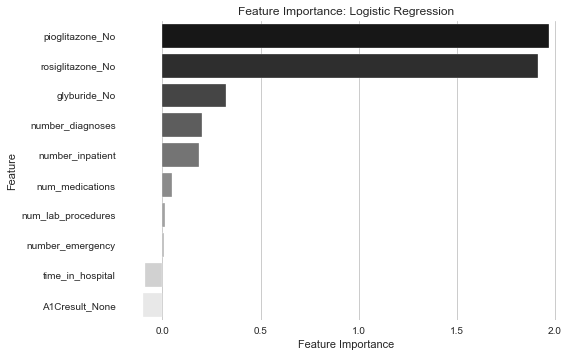

In [116]:
lr_feat_dict = {'Feature':X_train_smo.columns, 'Feature Importance':lr.coef_.reshape(lr.coef_.shape[1],)}
lr_feat_df = pd.DataFrame(lr_feat_dict)
lr_feat_df = lr_feat_df.sort_values('Feature Importance', ascending=False).head(10)
lr_feat_df

plt.figure()
sns.barplot(x = lr_feat_df['Feature Importance'], y = lr_feat_df['Feature'], palette = 'binary_r')
sns.set_style('whitegrid')
plt.title('Feature Importance: Logistic Regression')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

## Logistic Regression CV

- Confusion Matrix

In [128]:
# create model logistic as logistic regression using Sklearn 
from sklearn.linear_model import LogisticRegressionCV
logisticregCV = LogisticRegressionCV(tol=1e-7, penalty='l2', random_state = 123)
logisticregCV.fit(X_train_smo, y_train_smo)
YlogCV = logisticregCV.predict(X_test)

In [118]:
# Checking the accuracy of the model 
print(" The accuracy of the Logistic regression model:" ,logisticregCV.score(X_test, y_test))

 The accuracy of the Logistic regression model: 0.903516744738866


In [119]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, YlogCV))

[[12898   146]
 [ 1234    25]]


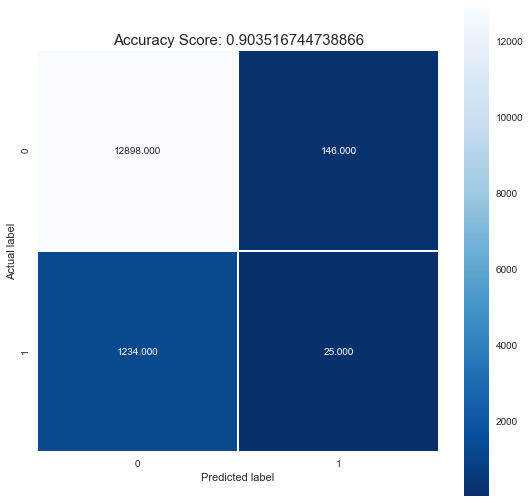

In [120]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(y_test, YlogCV), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(logisticregCV.score(X_test, y_test))
plt.title(all_sample_title, size = 15);

In [92]:
# Checking the summary of classification
from sklearn.metrics import classification_report
print(classification_report(y_test, YlogCV, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.91      0.99      0.95     13044
         YES       0.15      0.02      0.03      1259

    accuracy                           0.90     14303
   macro avg       0.53      0.50      0.49     14303
weighted avg       0.85      0.90      0.87     14303



In [93]:
YScreCV = logisticregCV.decision_function(X_test)

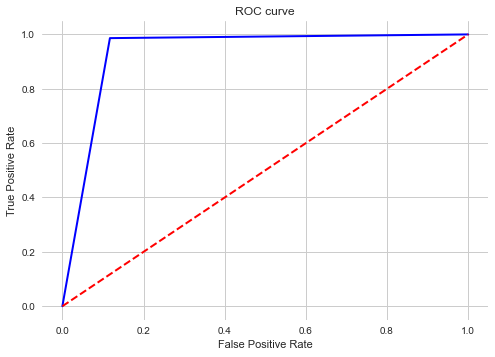

In [94]:
##Computing false and true positive rates
from sklearn.metrics import roc_curve

fpr, tpr,_=roc_curve(logisticregCV.predict(X_train_smo),y_train_smo,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()
##Creating the ROC,
plt.plot(fpr, tpr, color='blue',
 lw=2, label='ROC curve')
##Finding FPR and TPR,
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
##Splecifying the label and title,
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [96]:
# logistic regression CV
from sklearn.linear_model import LogisticRegressionCV
lr_cv=LogisticRegressionCV(random_state = 123)
lr_cv.fit(X_train_smo, y_train_smo)

LogisticRegressionCV(random_state=123, tol=1e-07)

In [104]:
y_train_preds = lr_cv.predict_proba(X_train)[:,1]
y_valid_preds = lr_cv.predict_proba(X_test)[:,1]

print('Logistic Regression CV')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Test:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_test,y_valid_preds, thresh)

Logistic Regression CV
Training:
AUC:0.558
accuracy:0.903
recall:0.019
precision:0.134
specificity:0.988
prevalence:0.088
 
Test:
AUC:0.547
accuracy:0.904
recall:0.020
precision:0.146
specificity:0.989
prevalence:0.088
 


In [43]:
readmit_proba = [i[1] for i in lr_cv.predict_proba(X_test)]
quant = pd.qcut(readmit_proba,10,labels=np.arange(1,11))
prob = {'Quantile':quant,'# Readmitted':readmit_proba,'y':y_test}

decile_lrcv = pd.DataFrame(prob).sort_values('Quantile')
dec1 = decile_lrcv.groupby('Quantile')['# Readmitted'].agg(['count','min','max','mean']).reset_index()
dec2 = decile_lrcv.groupby(['Quantile','y']).count().reset_index()
dec2 = dec2[dec2['y']==1]
decile_lrcv = pd.merge(dec2, dec1, how='inner',on ='Quantile').drop('y',1).\
        rename({'count':'Unique Patients', 'min':'Min Prob', 'mean':'Average Prob','max':'Max Prob'},axis=1)

decile_lrcv = decile_lrcv[decile_lrcv.columns[[0,2,1,3,4,5]]]
decile_lrcv['Percent Readmitted'] = decile_lrcv['# Readmitted']/decile_lrcv['Unique Patients']
decile_lrcv['Lift'] = decile_lrcv['Percent Readmitted'].apply(lambda x:10*x/decile_lrcv['Percent Readmitted'].sum())
decile_lrcv.style.hide_index()

Quantile,Unique Patients,# Readmitted,Min Prob,Max Prob,Average Prob,Percent Readmitted,Lift
1,1431,95,0.005164,0.038251,0.027893,0.066387,0.754198
2,1430,111,0.038254,0.052994,0.045694,0.077622,0.881838
3,1430,109,0.053003,0.067286,0.059978,0.076224,0.865949
4,1430,118,0.067286,0.084235,0.075945,0.082517,0.937449
5,1431,125,0.084236,0.101397,0.092764,0.087352,0.992366
6,1430,112,0.101404,0.123681,0.112094,0.078322,0.889782
7,1430,138,0.123692,0.152070,0.136872,0.096503,1.096339
8,1430,146,0.152073,0.192540,0.170893,0.102098,1.159895
9,1430,146,0.192613,0.264159,0.223799,0.102098,1.159895
10,1431,159,0.264166,0.940860,0.372185,0.111111,1.262290


In [44]:
tot_compdic_lrcv = {'Unique Patients': [decile_lrcv['Unique Patients'].sum(), decile_lrcv['Unique Patients'][8] + decile_lrcv['Unique Patients'][9]], 
               '# Readmitted': [decile_lrcv['# Readmitted'].sum(), decile_lrcv['# Readmitted'][8] + decile_lrcv['# Readmitted'][9]]}

tot_compdic_lrcv['Percent Readmitted'] = [tot_compdic_lrcv['# Readmitted'][0]/tot_compdic_lrcv['Unique Patients'][0],
                                      tot_compdic['# Readmitted'][1]/tot_compdic['Unique Patients'][1]]

tot_compdf_lrcv = pd.DataFrame(tot_compdic_lrcv, index = ['Random Sampling','Top 2 Quantiles'])

lr_readmit_rand = tot_compdf_lrcv['Percent Readmitted'][0].round(4)
lr_readmit_top_2 = (decile_lrcv['Percent Readmitted'][8] + decile_lrcv['Percent Readmitted'][9]).round(4)

print('')
print(f'If the top two quantiles are targeted instead of a random sampling, the percent readmitted increases from',
      lr_readmit_rand, 'to',lr_readmit_top_2)
print('')
tot_compdf_lrcv


If the top two quantiles are targeted instead of a random sampling, the percent readmitted increases from 0.088 to 0.2132



,Unique Patients,# Readmitted,Percent Readmitted
Random Sampling,14303,1259,0.088023
Top 2 Quantiles,2861,305,0.096819


In [45]:
lrcv_feat_dict = {'Feature':X_train_res.columns, 'Feature Importance':lr_cv.coef_.reshape(lr.coef_.shape[1],)}
lrcv_feat_df = pd.DataFrame(lrcv_feat_dict)
lrcv_feat_df = lrcv_feat_df.sort_values('Feature Importance', ascending=False).head(10)

plt.figure()
sns.barplot(x = lrcv_feat_df['Feature Importance'], y = lrcv_feat_df['Feature'], palette = 'binary_r')
sns.set_style('whitegrid')
plt.title('Feature Importance: Logistic Regression with Cross Validation')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

NameError: name 'X_train_res' is not defined

### Random Forest Classifier 

In [89]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 123)
rf.fit(X_train_smo, y_train_smo)

RandomForestClassifier(max_depth=6, random_state=123)

In [90]:
y_train_preds = rf.predict_proba(X_train_smo)[:,1]
y_test_preds = rf.predict_proba(X_test)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train_smo,y_train_preds, thresh)
print('Test:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_test,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.927
accuracy:0.858
recall:0.838
precision:0.873
specificity:0.878
prevalence:0.500
 
Test:
AUC:0.572
accuracy:0.809
recall:0.174
precision:0.114
specificity:0.870
prevalence:0.088
 


### Random Forest Classifier Part 2

In [79]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=123,n_estimators=500)
random_forest.fit(X_train_smo, y_train_smo)
Yrandforest = random_forest.predict(X_test)

In [80]:
#Calculating the score,
scorey =random_forest.predict_proba(X_test)[:,1]
rfpr, rtpr, thresholds = roc_curve(y_test, scorey)

In [82]:
#Checking the accuracy,

print(" Accuracy of Randomeforest classification: ", random_forest.score(X_test, y_test))

 Accuracy of Randomeforest classification:  0.906523107040481


In [83]:
#Printing the confusion matrix,
print(confusion_matrix(y_test, Yrandforest))

[[12958    86]
 [ 1251     8]]


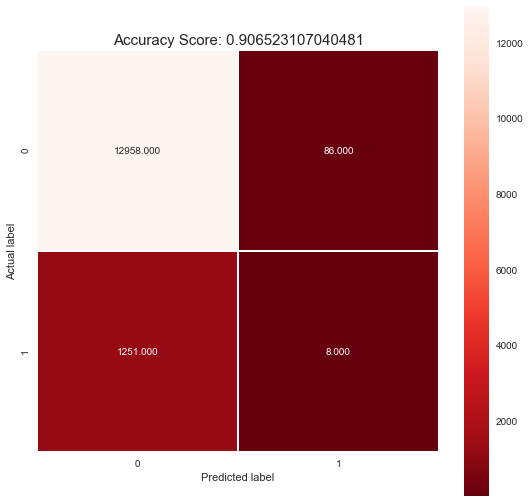

In [84]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(y_test, Yrandforest), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(random_forest.score(X_test, y_test))
plt.title(all_sample_title, size = 15);

In [85]:
print(classification_report(y_test, Yrandforest, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.91      0.99      0.95     13044
         YES       0.09      0.01      0.01      1259

    accuracy                           0.91     14303
   macro avg       0.50      0.50      0.48     14303
weighted avg       0.84      0.91      0.87     14303



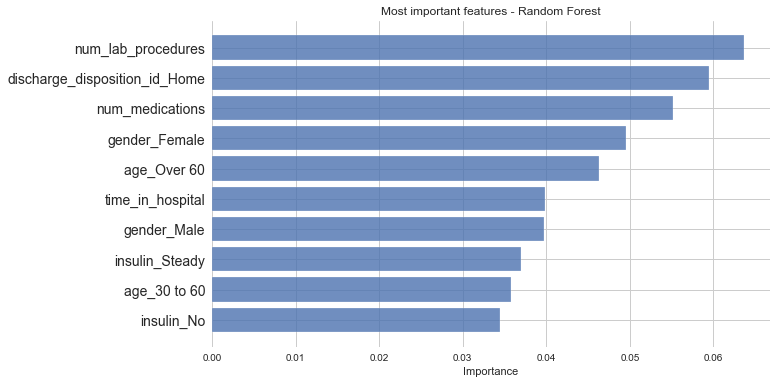

In [86]:
#Determining which features are most important,
feature_names = X_train_smo.columns
feature_imports = random_forest.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest')
plt.show()

### XGBoost Classifier 

In [91]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed = 42)
xgb_clf.fit(X_train_smo, y_train_smo)

[19:04:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [92]:
xgb_clf.fit(X_train_smo, y_train_smo)
Yxgb = xgb_clf.predict(X_test)

[19:07:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [93]:
scorey = xgb_clf.predict_proba(X_test)[:,1]
rfpr, rtpr, thresholds = roc_curve(y_test, scorey)

In [95]:
print(" Accuracy of Randomeforest classification: ", xgb_clf.score(X_test, y_test))

 Accuracy of Randomeforest classification:  0.8933790113962106
